## Generation of the map band limited

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import astropy.io.fits as fits
import camb

In [96]:
def generate_power_spectra_CAMB(Nside,  r=10**(-2), Alens=1, H0=67.5, ombh2=0.022, omch2=0.122, mnu=0.06, omk=0, tau=0.06, ns=0.965, lens_potential_accuracy=1, nt=0, ntrun=0, type_power='total', typeless_bool=False):
    """
    Return [Cl^TT, Cl^EE, Cl^BB, Cl^TE]
    """
    lmax = 2*Nside
    # pars = camb.CAMBparams(max_l_tensor=lmax, parameterization='tensor_param_indeptilt')
    pars = camb.CAMBparams(max_l_tensor=lmax)
    pars.WantTensors = True

    pars.Accuracy.AccurateBB = True
    pars.Accuracy.AccuratePolarization = True
    pars.set_cosmology(H0=H0, ombh2=ombh2, omch2=omch2, mnu=mnu, omk=omk, tau=tau, Alens=Alens)
    pars.InitPower.set_params(As=2e-9, ns=ns, r=r, parameterization='tensor_param_indeptilt', nt=nt, ntrun=ntrun)
    pars.max_eta_k_tensor = lmax + 100  # 15000  # 100

    # pars.set_cosmology(H0=H0)
    pars.set_for_lmax(lmax, lens_potential_accuracy=lens_potential_accuracy)

    print("Calculating spectra from CAMB !")
    results = camb.get_results(pars)

    powers = results.get_cmb_power_spectra(pars, CMB_unit='muK', raw_cl=True, lmax=lmax)    
    if typeless_bool:
        return powers
    return powers[type_power]

In [97]:
nside = 512
camb_cls = generate_power_spectra_CAMB(nside)

Calculating spectra from CAMB !


In [4]:
maps_TQU = hp.synfast(camb_cls.T,nside, new=True)

/global/homes/m/mag/.local/lib/python3.8/site-packages/healpy/sphtfunc.py:822: UserWarning: Sigma is 0.000000 arcmin (0.000000 rad) 
  warnings.warn(
/global/homes/m/mag/.local/lib/python3.8/site-packages/healpy/sphtfunc.py:827: UserWarning: -> fwhm is 0.000000 arcmin
  warnings.warn(


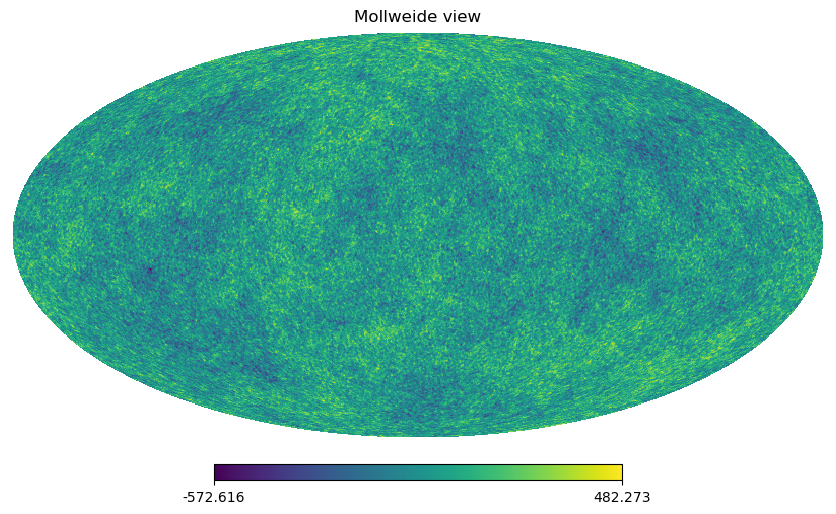

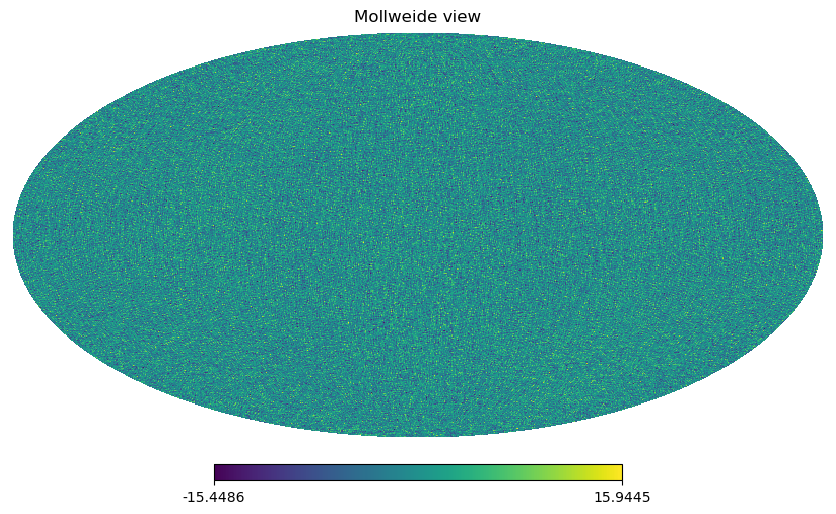

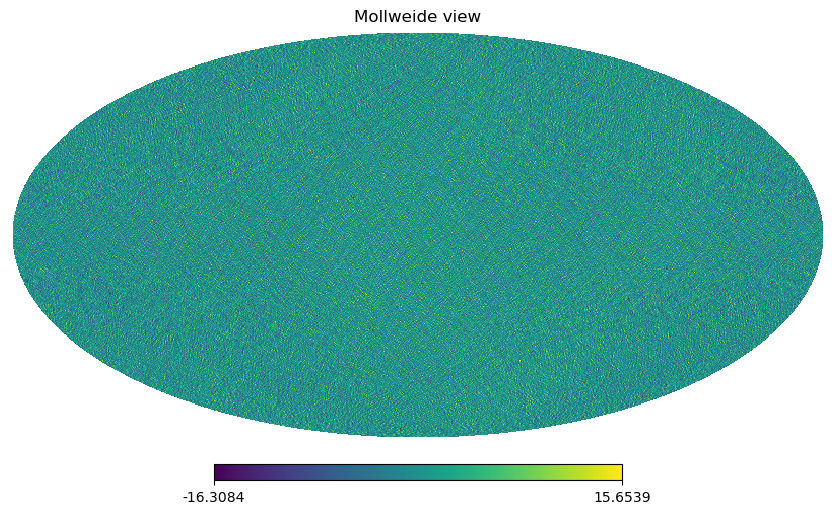

In [5]:
hp.mollview(maps_TQU[0])
hp.mollview(maps_TQU[1])
hp.mollview(maps_TQU[2])

In [85]:
np.average(maps_TQU[0])

-2.043008139540614e-05

In [86]:
np.average(maps_TQU[1])

-0.09374994121948653

In [87]:
np.average(maps_TQU[2])

-0.0013786959073347187

In [88]:
cls_retrieved = hp.anafast(maps_TQU, lmax=2*nside)

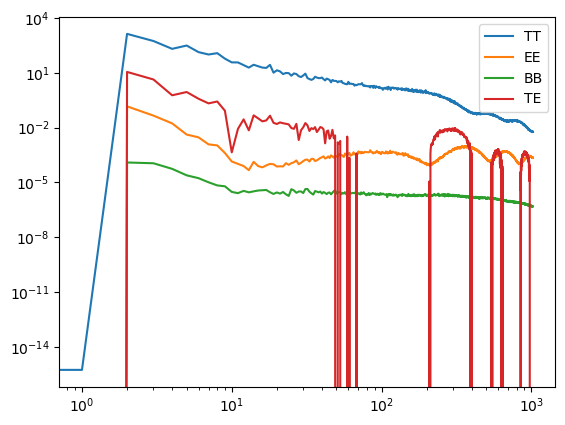

In [89]:
ell_arange = np.arange(cls_retrieved.shape[1])

plt.plot(ell_arange, cls_retrieved.T[:,:4])
plt.loglog()
plt.legend(["TT", "EE", 'BB', 'TE'])
plt.show()

In [11]:
def save_map_Xpure_from_maps(maps_TQU, directory_path='', outname=''):
    """ maps_TQU must have the dimension (3, 12*nside**2)
    """
    print('Shape maps TQU', maps_TQU.shape)
    print('Recording 3-maps in', directory_path, outname)
    map_names = ['T', 'Q', 'U']
    if directory_path=='':
        raise Exception('NO DIRECTORY PATH TO SAVE !!!')
        return
    list_hdu = [fits.PrimaryHDU(maps_TQU)]
    list_hdu.append(fits.BinTableHDU.from_columns([fits.Column(name=map_names[i], array=maps_TQU[i,:], format='1D') for i in range(3)]))

    hdu_list = fits.HDUList(list_hdu)
    Header = fits.Header()
    endfile = ''
    if outname[-5:] != '.fits':
        endfile = '.fits'
    hdu_list.writeto(directory_path+outname+endfile,overwrite=True)

In [28]:
path_output_map = '/global/homes/m/mag/midapack/mappraiser/src/test_wiener_filter/'
outname = 'Map_test_band_limited.fits'
save_map_Xpure_from_maps(maps_TQU, directory_path=path_output_map, outname=outname)


Shape maps TQU (3, 3145728)
Recording 3-maps in /global/homes/m/mag/midapack/mappraiser/src/test_wiener_filter/ Map_test_band_limited.fits


In [12]:
def save_fits_file_from_array(array_to_save, name_column_array, directory_path='', outname=''):
    """ Save arrays with corresponding name_column_array in directory_path+outname
        Note that the first index of the array_to_save will correspond to the number of columns recorded in the fits file

        To save c_ells, the array_to_save should be a vector in 1 dimension
        name_column_array must be a list of the name of the array, even if there is only 1 array
    """
    
    print('Shape array', array_to_save.shape)
    print('Recording 3-maps in', directory_path, outname)
    if directory_path=='':
        raise Exception('NO DIRECTORY PATH GIVEN TO SAVE FITS FILE !')
    
    dimension_array = array_to_save.shape[0]

    list_hdu = [fits.PrimaryHDU(array_to_save)]
    if len(array_to_save.shape) == 1:
        list_hdu.append(fits.BinTableHDU.from_columns([fits.Column(name=name_column_array[0], array=array_to_save, format='1D')]))
    else :
        list_hdu.append(fits.BinTableHDU.from_columns([fits.Column(name=name_column_array[i], array=array_to_save[i,:], format='1D') for i in range(dimension_array)]))

    hdu_list = fits.HDUList(list_hdu)
    # Header = fits.Header()


    if directory_path[-1] != '/':
        directory_path += '/'
    endfile = ''
    if outname[-5:] != '.fits':
        endfile = '.fits'
    hdu_list.writeto(directory_path+outname+endfile,overwrite=True)


In [104]:
camb_cls.shape

(1025, 4)

In [114]:
np.where(camb_cls[:,3]<0)


(array([  53,   54,   55,   56,   57,   58,   59,   60,   61,   62,   63,
          64,   65,   66,   67,   68,   69,   70,   71,   72,   73,   74,
          75,   76,   77,   78,   79,   80,   81,   82,   83,   84,   85,
          86,   87,   88,   89,   90,   91,   92,   93,   94,   95,   96,
          97,   98,   99,  100,  101,  102,  103,  104,  105,  106,  107,
         108,  109,  110,  111,  112,  113,  114,  115,  116,  117,  118,
         119,  120,  121,  122,  123,  124,  125,  126,  127,  128,  129,
         130,  131,  132,  133,  134,  135,  136,  137,  138,  139,  140,
         141,  142,  143,  144,  145,  146,  147,  148,  149,  150,  151,
         152,  153,  154,  155,  156,  157,  158,  159,  160,  161,  162,
         163,  164,  165,  166,  167,  168,  169,  170,  171,  172,  173,
         174,  175,  176,  177,  178,  179,  180,  181,  182,  183,  184,
         185,  186,  187,  188,  189,  190,  191,  192,  193,  194,  195,
         196,  197,  198,  199,  200, 

In [125]:
save_fits_file_from_array(np.ravel(camb_cls.T, order='F'), ['cell'], directory_path='/global/homes/m/mag/midapack/mappraiser/src/test_wiener_filter/', outname='cls_limited_1024')
camb_cls_woTE = np.zeros_like(camb_cls)
camb_cls_woTE[:,:2] = camb_cls[:,:2]
save_fits_file_from_array(np.ravel(camb_cls_woTE.T, order='F'), ['cell'], directory_path='/global/homes/m/mag/midapack/mappraiser/src/test_wiener_filter/', outname='cls_limited_1024_woTE')

Shape array (4100,)
Recording 3-maps in /global/homes/m/mag/midapack/mappraiser/src/test_wiener_filter/ cls_limited_1024
Shape array (4100,)
Recording 3-maps in /global/homes/m/mag/midapack/mappraiser/src/test_wiener_filter/ cls_limited_1024_woTE


In [99]:
dir_path = '/global/homes/m/mag/midapack/mappraiser/src/test_wiener_filter/map_files/'
path_output_filtered_maps = '/global/cscratch1/sd/mag/WF_work/WF_Tests/mapfile_filtered_{}.fits'
path_output_filtered_maps = '/global/cscratch1/sd/mag/WF_work/WF_Tests/mapfile_filtered_bis_{}.fits'
path_output_filtered_maps = '/global/cscratch1/sd/mag/WF_work/WF_Tests/mapfile_filtered_wpow_{}.fits'
path_output_filtered_maps = dir_path + 'mapfile_filtered_wonest_{}.fits'
path_output_filtered_maps = dir_path + 'mapfile_filtered_wonest_sq_{}.fits'
path_output_filtered_maps = dir_path + 'mapfile_filtered_wonest_unit_{}.fits'
path_output_filtered_maps = dir_path + 'mapfile_filtered_wonest_woTT_woTE_{}.fits'
path_output_filtered_maps = dir_path + 'mapfile_filtered_wonest_woTT_woTE_b_{}.fits'



maps_output = np.ones((3,12*nside**2))

for i in range(3):
    maps_output[i] = hp.read_map(path_output_filtered_maps.format(i))

/global/homes/m/mag/.local/lib/python3.8/site-packages/healpy/fitsfunc.py:368: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  warnings.warn(
/global/homes/m/mag/.local/lib/python3.8/site-packages/healpy/fitsfunc.py:391: UserWarning: NSIDE = 512
  warnings.warn("NSIDE = {0:d}".format(nside))
/global/homes/m/mag/.local/lib/python3.8/site-packages/healpy/fitsfunc.py:400: UserWarning: ORDERING = RING in fits file
  warnings.warn("ORDERING = {0:s} in fits file".format(ordering))
/global/homes/m/mag/.local/lib/python3.8/site-packages/healpy/fitsfunc.py:426: UserWarning: No INDXSCHM keyword in header file : assume IMPLICIT
  warnings.warn("No INDXSCHM keyword in header file : " "assume {}".format(schm))
/global/homes/m/mag/.local/lib/python3.8/site-packages/healpy/

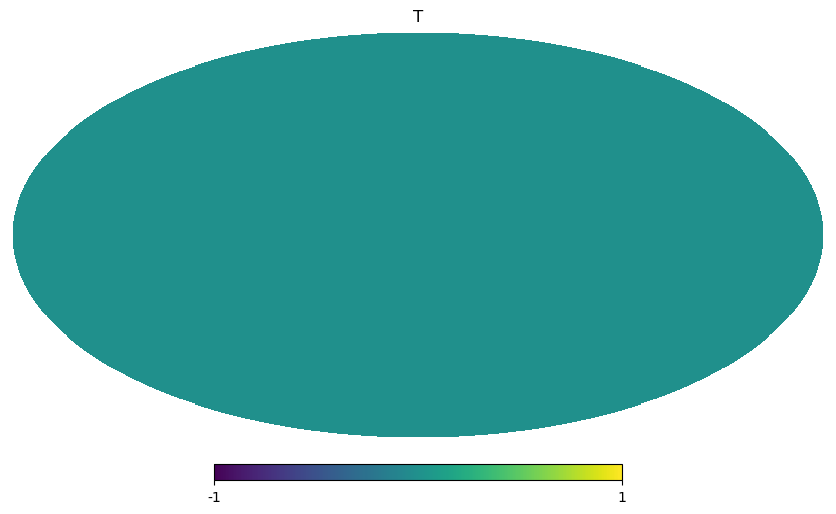

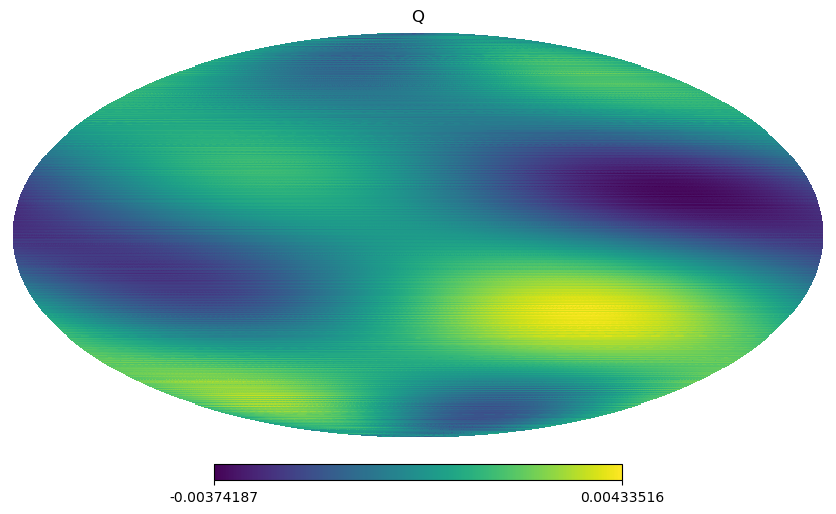

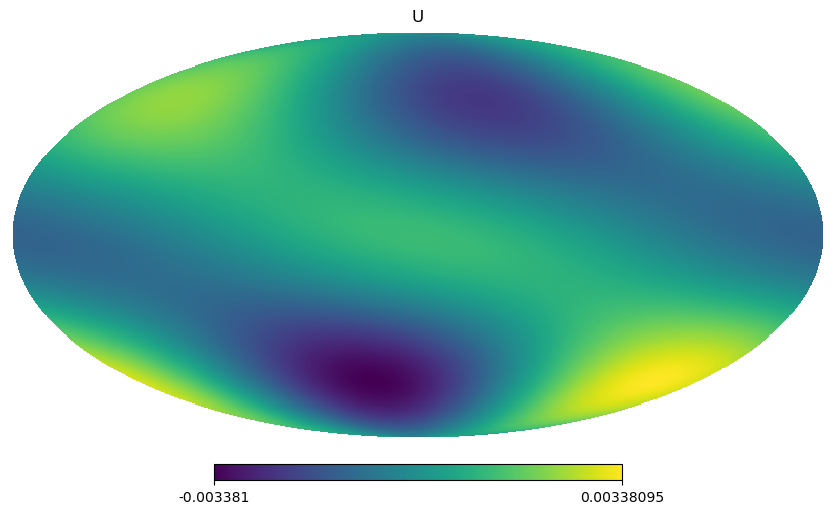

In [100]:
hp.mollview(maps_output[0], title='T')
hp.mollview(maps_output[1], title='Q')
hp.mollview(maps_output[2], title='U')

(array([ 2447.,  2576.,  2656.,  2766.,  2754.,  2731.,  2761.,  2790.,
         2742.,  2821.,  2770.,  2791.,  2862.,  2800.,  2894.,  2892.,
         2879.,  2927.,  2947.,  2867.,  2952.,  2943.,  2946.,  3007.,
         3028.,  3043.,  3055.,  3070.,  3051.,  3103.,  3108.,  3108.,
         3185.,  3192.,  3226.,  3239.,  3275.,  3223.,  3302.,  3299.,
         4474.,  8324.,  8112.,  8198.,  8290.,  8337.,  8392.,  8425.,
         8452.,  8651.,  8696.,  8724.,  8701.,  8820.,  8864.,  8995.,
         9052.,  9139.,  9238.,  9318.,  9369.,  9513.,  9589.,  9679.,
         9796.,  9845.,  9969., 10085., 10245., 10370., 10473., 10701.,
        10728., 10834., 11108., 11165., 11413., 11632., 11783., 12173.,
        15075., 23982., 24792., 25578., 26303., 27484., 29023., 30960.,
        34242., 40564., 38786., 32221., 29335., 27597., 26182., 25174.,
        24437., 23610., 23047., 22468., 22124., 21638., 21326., 20921.,
        20892., 20435., 20309., 20025., 19812., 19582., 19504., 

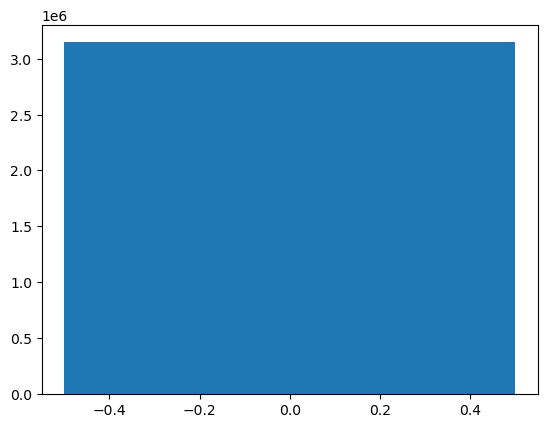

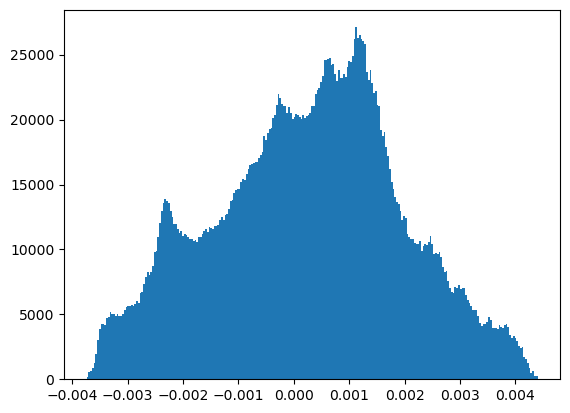

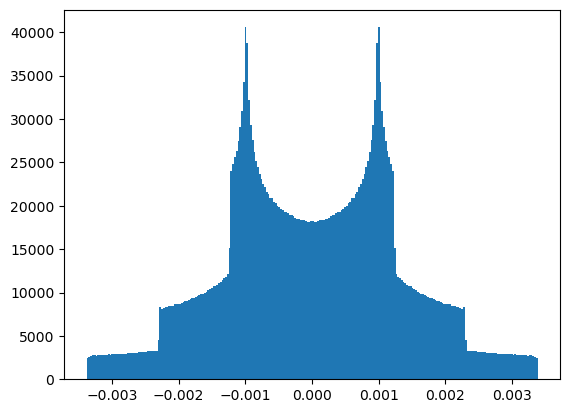

In [101]:
plt.figure()
plt.hist(maps_output[0], bins='auto')
plt.figure()
plt.hist(maps_output[1], bins='auto')
plt.figure()
plt.hist(maps_output[2], bins='auto')

In [102]:
c_ells_output = hp.anafast(maps_output, lmax=2*nside)

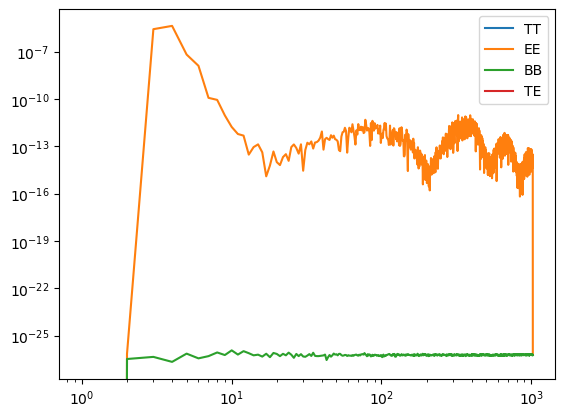

In [103]:
ell_arange = np.arange(c_ells_output.shape[1])

plt.plot(ell_arange, c_ells_output.T[:,:4])
plt.loglog()
plt.legend(["TT", "EE", 'BB', 'TE'])
plt.show()

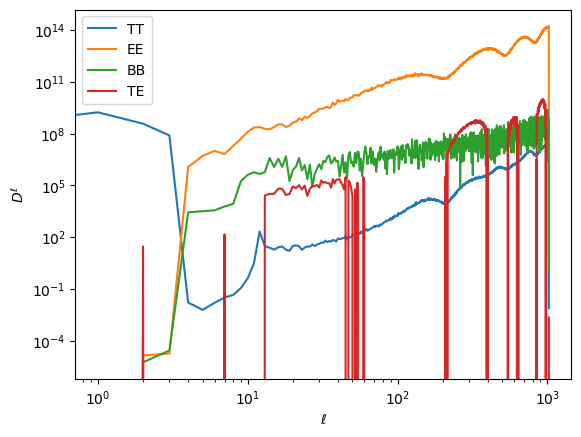

In [95]:
ell_arange = np.arange(c_ells_output.shape[1])

correl_name = ["TT", "EE", 'BB', 'TE']
factor = ell_arange*(ell_arange+1)/(2*np.pi)
for i in range(4):
    plt.plot(ell_arange, factor*c_ells_output.T[:,i], label=correl_name[i])
plt.loglog()
plt.legend()
plt.xlabel(r'$\ell$')
plt.ylabel(r'$D^{\ell}$')
plt.show()

In [22]:
c_ells_test = hp.anafast(maps_output[0], lmax=2*nside)

In [23]:
c_ells_test.shape

(1025,)

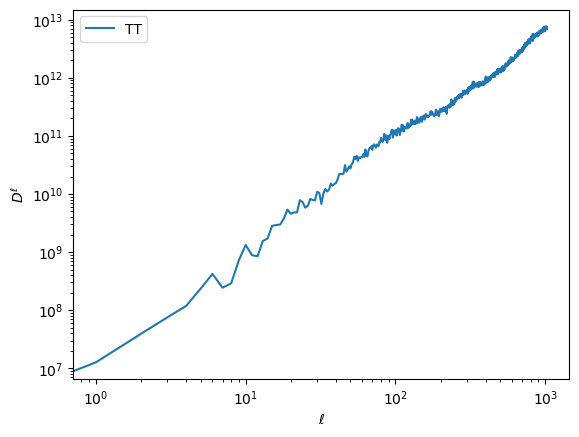

In [24]:
ell_arange_T = np.arange(c_ells_test.shape[0])


factor = ell_arange_T*(ell_arange_T+1)/(2*np.pi)

plt.plot(ell_arange_T, factor*c_ells_test, label='TT')
plt.loglog()
plt.legend()
plt.xlabel(r'$\ell$')
plt.ylabel(r'$D^{\ell}$')
plt.show()

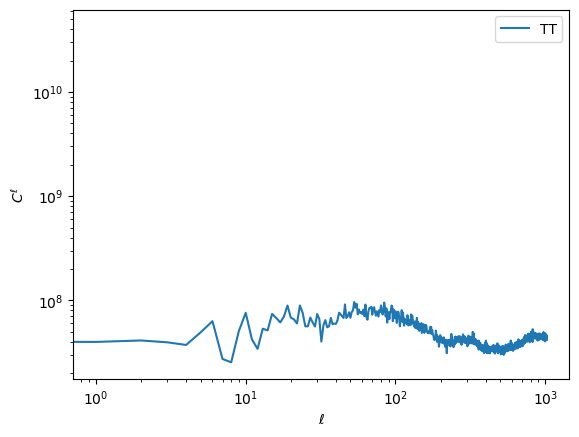

In [25]:
ell_arange_T = np.arange(c_ells_test.shape[0])


factor = ell_arange_T*(ell_arange_T+1)/(2*np.pi)

plt.plot(ell_arange_T, c_ells_test, label='TT')
plt.loglog()
plt.legend()
plt.xlabel(r'$\ell$')
plt.ylabel(r'$C^{\ell}$')
plt.show()

In [26]:
alms_Healpy = hp.map2alm(maps_TQU, lmax=2*nside)

In [27]:
alms_Healpy.shape

(3, 525825)

In [28]:
camb_cls.shape

(1025, 4)

In [109]:
lmax = 2*nside
inv_covariance_matrix_woTETT = np.zeros((lmax, 3,3))

for ell in range(2,lmax):
    cov_matrix_woTETT = np.zeros(9)
    cov_matrix_woTETT[0] = camb_cls_woTE[ell,0]
    cov_matrix_woTETT[4] = camb_cls_woTE[ell,1]
    cov_matrix_woTETT[8] = camb_cls_woTE[ell,2]
    cov_matrix_woTETT[1] = camb_cls_woTE[ell,3]
    cov_matrix_woTETT[3] = camb_cls_woTE[ell,3]
    # inv_covariance_matrix[ell] = np.linalg.pinv(cov_matrix.reshape(3,3))
    inv_covariance_matrix_woTETT[ell] = np.linalg.pinv(cov_matrix_woTETT.reshape(3,3))

In [123]:
camb_cls_woTE

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.02199001e+03, 3.35969187e-02, 0.00000000e+00, 0.00000000e+00],
       ...,
       [5.91008604e-03, 2.20934233e-04, 0.00000000e+00, 0.00000000e+00],
       [5.90311951e-03, 2.19432405e-04, 0.00000000e+00, 0.00000000e+00],
       [5.89695383e-03, 2.17914688e-04, 0.00000000e+00, 0.00000000e+00]])

In [124]:
test = camb_cls_woTE.ravel('F')
print(test[0], test[1], test[2], test[3], test[1024], test[1025], test[1026])

0.0 0.0 1021.9900118923628 483.7071509323783 0.005896953828991165 0.0 0.0


In [117]:
for ell in range(2,10):
    print(camb_cls_woTE[ell,0], camb_cls_woTE[ell,1], camb_cls_woTE[ell,2], camb_cls_woTE[ell,3])

1021.9900118923628 0.03359691870297146 0.0 0.0
483.7071509323783 0.02315608128510505 0.0 0.0
274.5013456857929 0.013027637334701185 0.0 0.0
175.10680532257444 0.006302294117185589 0.0 0.0
121.17800118202051 0.0027046606697523016 0.0 0.0
89.00006953691134 0.001109326489514659 0.0 0.0
68.32718380551444 0.0005157924401573135 0.0 0.0
54.308079002182154 0.0003124439164257774 0.0 0.0


In [110]:
for ell in range(2,10):
    print(inv_covariance_matrix_woTETT[ell])

[[9.78483144e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.97646343e+01 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]]
[[2.06736658e-03 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 4.31851999e+01 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]]
[[3.64296939e-03 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.67598893e+01 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]]
[[5.71080032e-03 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.58672379e+02 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]]
[[8.25232295e-03 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 3.69732148e+02 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]]
[[1.12359463e-02 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 9.01447869e+02 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]]
[[1.46354634e-02 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.93876436e+03 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.

In [ ]:
 #### ell= 2 
1021.9900119    0.0000000       0.0000000 
0.0000000       0.0000000       0.0000000 
0.0000000       0.0000000       0.0000000 

 #### ell= 3 
483.7071509     0.0000000       0.0000000 
0.0000000       0.0335969       0.0000000 
0.0000000       0.0000000       0.0000000 

 #### ell= 4 
274.5013457     0.0000000       0.0000000 
0.0000000       0.0231561       0.0000000 
0.0000000       0.0000000       0.0000000 

 #### ell= 5 
175.1068053     0.0000000       0.0000000 
0.0000000       0.0130276       0.0000000 
0.0000000       0.0000000       0.0000000 

 #### ell= 6 
121.1780012     0.0000000       0.0000000 
0.0000000       0.0063023       0.0000000 
0.0000000       0.0000000       0.0000000 

 #### ell= 7 
89.0000695      0.0000000       0.0000000 
0.0000000       0.0027047       0.0000000 
0.0000000       0.0000000       0.0000000 

 #### ell= 8 
68.3271838      0.0000000       0.0000000 
0.0000000       0.0011093       0.0000000 
0.0000000       0.0000000       0.0000000 

 #### ell= 9 
54.3080790      0.0000000       0.0000000 
0.0000000       0.0005158       0.0000000 
0.0000000       0.0000000       0.0000000 

In [38]:
lmax = 2*nside
inv_covariance_matrix = np.zeros((lmax, 3,3))

for ell in range(2,lmax):
    cov_matrix = np.zeros(9)
    cov_matrix[0] = camb_cls[ell,0]
    cov_matrix[4] = camb_cls[ell,1]
    cov_matrix[8] = camb_cls[ell,2]
    cov_matrix[1] = camb_cls[ell,3]
    cov_matrix[3] = camb_cls[ell,3]
    # inv_covariance_matrix[ell] = np.linalg.pinv(cov_matrix.reshape(3,3))
    inv_covariance_matrix[ell] = np.linalg.inv(cov_matrix.reshape(3,3))

In [41]:
lmax = 2*nside
alm_T, alm_E, alm_B = alms_Healpy
alm_T_output, alm_E_output, alm_B_output = np.ones_like(alm_T), np.ones_like(alm_E), np.ones_like(alm_B)
for ell in range(2,lmax):
    min_range = int(ell*(ell+1)/2)
    max_range = int((ell+2)*(ell+1)/2)
    alm_T_output[min_range:max_range+1] = (alm_T[min_range:max_range+1]/inv_covariance_matrix[ell][0,0] + alm_E[min_range:max_range+1]/inv_covariance_matrix[ell][0,1])
    alm_E_output[min_range:max_range+1] = (alm_E[min_range:max_range+1]/inv_covariance_matrix[ell][1,1] + alm_T[min_range:max_range+1]/inv_covariance_matrix[ell][1,0])
    alm_B_output[min_range:max_range+1] = alm_B[min_range:max_range+1]/inv_covariance_matrix[ell][2,2]


In [40]:
lmax = 2*nside
alm_T, alm_E, alm_B = alms_Healpy
alm_T_output, alm_E_output, alm_B_output = np.ones_like(alm_T), np.ones_like(alm_E), np.ones_like(alm_B)
for ell in range(2,lmax):
    min_range = int(ell*(ell+1)/2)
    max_range = int((ell+2)*(ell+1)/2)
    alm_T_output[min_range:max_range+1] = (alm_T[min_range:max_range+1]/np.sqrt(inv_covariance_matrix[ell][0,0]) + alm_E[min_range:max_range+1]/np.sqrt(inv_covariance_matrix[ell][0,1]))
    alm_E_output[min_range:max_range+1] = (alm_E[min_range:max_range+1]/np.sqrt(inv_covariance_matrix[ell][1,1]) + alm_T[min_range:max_range+1]/np.sqrt(inv_covariance_matrix[ell][1,0]))
    alm_B_output[min_range:max_range+1] = alm_B[min_range:max_range+1]/np.sqrt(inv_covariance_matrix[ell][2,2])


/tmp/ipykernel_56396/1651361668.py:7: RuntimeWarning: invalid value encountered in sqrt
  alm_T_output[min_range:max_range+1] = (alm_T[min_range:max_range+1]/np.sqrt(inv_covariance_matrix[ell][0,0]) + alm_E[min_range:max_range+1]/np.sqrt(inv_covariance_matrix[ell][0,1]))
/tmp/ipykernel_56396/1651361668.py:7: RuntimeWarning: invalid value encountered in divide
  alm_T_output[min_range:max_range+1] = (alm_T[min_range:max_range+1]/np.sqrt(inv_covariance_matrix[ell][0,0]) + alm_E[min_range:max_range+1]/np.sqrt(inv_covariance_matrix[ell][0,1]))
/tmp/ipykernel_56396/1651361668.py:8: RuntimeWarning: invalid value encountered in sqrt
  alm_E_output[min_range:max_range+1] = (alm_E[min_range:max_range+1]/np.sqrt(inv_covariance_matrix[ell][1,1]) + alm_T[min_range:max_range+1]/np.sqrt(inv_covariance_matrix[ell][1,0]))
/tmp/ipykernel_56396/1651361668.py:8: RuntimeWarning: invalid value encountered in divide
  alm_E_output[min_range:max_range+1] = (alm_E[min_range:max_range+1]/np.sqrt(inv_covariance

In [42]:
maps_healpy_alms = hp.alm2map((alm_T_output, alm_E_output, alm_B_output), nside=nside)

/global/homes/m/mag/.local/lib/python3.8/site-packages/healpy/sphtfunc.py:822: UserWarning: Sigma is 0.000000 arcmin (0.000000 rad) 
  warnings.warn(
/global/homes/m/mag/.local/lib/python3.8/site-packages/healpy/sphtfunc.py:827: UserWarning: -> fwhm is 0.000000 arcmin
  warnings.warn(


In [43]:
maps_healpy_alms.shape

(3, 3145728)

In [44]:
cls_healpy_alms = hp.anafast(maps_healpy_alms, lmax=2*nside)


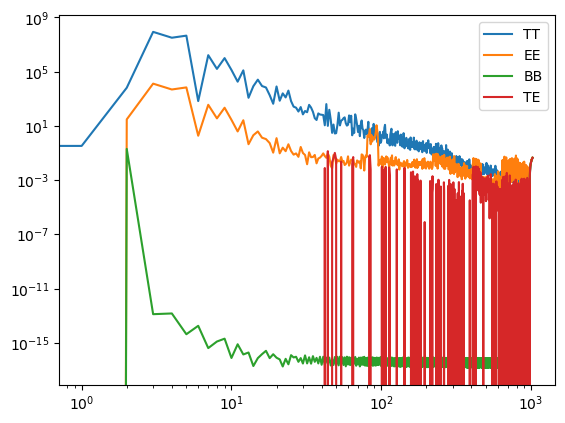

In [45]:
ell_arange = np.arange(cls_healpy_alms.shape[1])

plt.plot(ell_arange, cls_healpy_alms.T[:,:4])
plt.loglog()
plt.legend(["TT", "EE", 'BB', 'TE'])
plt.show()

(array([1., 0., 0., ..., 0., 0., 1.]),
 array([-352.00636246, -351.69197763, -351.37759279, ...,  344.98482078,
         345.29920562,  345.61359046]),
 <a list of 2219 Patch objects>)

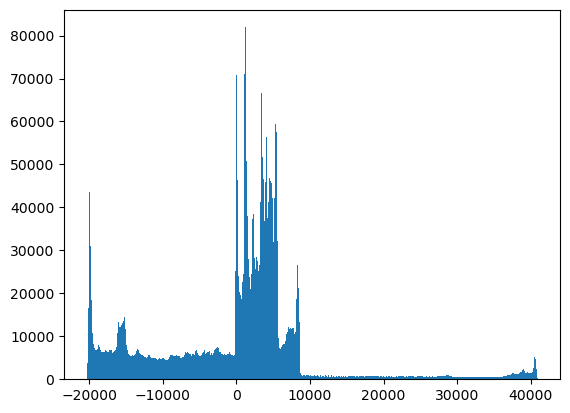

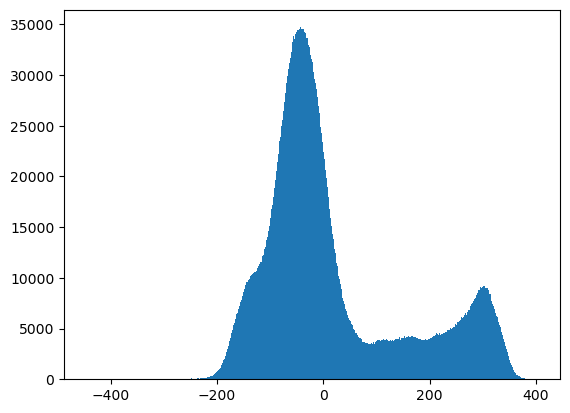

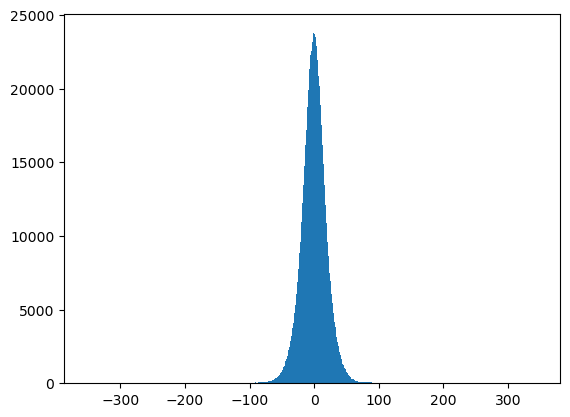

In [78]:
plt.figure()
plt.hist(maps_healpy_alms[0], bins='auto')
plt.figure()
plt.hist(maps_healpy_alms[1], bins='auto')
plt.figure()
plt.hist(maps_healpy_alms[2], bins='auto')